Install dependencies

In [158]:
!sudo apt-get update
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# install required system dependencies
!apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

Imports

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.pyplot import figure

import gym
import torch 
from torch.utils import data
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import random
from gym import wrappers
import copy
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
STUDENTID1=2017257239;
STUDENTID2=2016236736;

print("imports Done!")



imports Done!


Deep RL Replay Buffer

In [160]:

class ReplayBuffer:
    def __init__(self, size, input_shape,dev):
        self.size = size
        self.counter = 0
        self.state_buffer = torch.zeros((self.size, input_shape))
        self.action_buffer = torch.zeros(self.size, dtype=torch.int64)
        self.reward_buffer = torch.zeros(self.size)
        self.new_state_buffer = torch.zeros((self.size, input_shape))
        self.terminal_buffer = torch.zeros(self.size)
        self.state_buffer.to(dev)
        self.action_buffer.to(dev)
        self.reward_buffer.to(dev)
        self.new_state_buffer.to(dev)
        self.terminal_buffer.to(dev)
        self.dev=dev;



    def store_tuples(self, state, action, reward, new_state, done):
        idx = self.counter % self.size
        self.state_buffer[idx] = state
        self.action_buffer[idx] = action
        self.reward_buffer[idx] = reward
        self.new_state_buffer[idx] = new_state
        self.terminal_buffer[idx] = done
        self.counter += 1

    def sample_buffer(self, batch_size):
        max_buffer = min(self.counter, self.size)
        batch = np.random.choice(max_buffer, batch_size, replace=False)
        state_batch = self.state_buffer[batch].to(self.dev)
        action_batch = self.action_buffer[batch].to(self.dev)
        reward_batch = self.reward_buffer[batch].to(self.dev)
        new_state_batch = self.new_state_buffer[batch].to(self.dev)
        done_batch = self.terminal_buffer[batch].to(self.dev)

        return state_batch, action_batch, reward_batch, new_state_batch, done_batch
    def last_buffer(self, batch_size):
        state_batch = self.state_buffer[-1:-batch_size].to(self.dev)
        action_batch = self.action_buffer[-1:-batch_size].to(self.dev)
        reward_batch = self.reward_buffer[-1:-batch_size].to(self.dev)
        new_state_batch = self.new_state_buffer[-1:-batch_size].to(self.dev)
        done_batch = self.terminal_buffer[-1:-batch_size].to(self.dev)

        return state_batch, action_batch, reward_batch, new_state_batch, done_batch


Default DQN arquitecture

In [161]:
class DQN(nn.Module):

    def __init__(self, inputs, outputs,dfactor):
        super(DQN, self).__init__()
        
        self.input_size=inputs;
        self.output_size=outputs;
        self.discount_factor=dfactor;
        nn.Module.__init__(self)
        self.layers = nn.Sequential(
           #Add your code here
           nn.Linear(in_features=4 , out_features=16),#16
           nn.LeakyReLU(),
           nn.Linear(in_features=16 , out_features=2)#2
        )


    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self,  x):

        return self.layers(x)

    def policy(self,state):
       with torch.no_grad():
            return self.__call__(state).argmax()
     
    def getPolicy(self,state,eps_threshold):
        sample = random.random()
        if sample > eps_threshold:
            with torch.no_grad():
 
                return self.__call__(state).argmax()
        else:
            return  torch.tensor([[random.randrange(self.output_size)]], device=device, dtype=torch.long)



 

OpenAI Environment CartPole-v0

###    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.
###    Source:
        This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson
###    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
###    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        Note: The amount the velocity that is reduced or increased is not fixed; it depends on the angle the pole is pointing. This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it
###    Reward:
        Reward is 1 for every step taken, including the termination step
###    Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
###    Episode Termination:
        Pole Angle is more than 12 degrees.
        Cart Position is more than 2.4 (center of the cart reaches the edge of the display).
        Episode length is greater than 200.
###     Solved Requirements:
        Considered solved when the average return is greater than or equal to 195.0 over 100 consecutive trials.

DQN movie generation (for visual evaluation in Google Colab)

In [162]:
def createMovie(Network,Filename):
    env = gym.make("CartPole-v0")
    envX = wrappers.Monitor(env, './videos/'+Filename,force=True)

    observation = envX.reset()

    i=0
    Network.eval()

    while True:
        envX.render()
        
        state=torch.Tensor(observation).to(device)
      
        action = Network.policy(state);
             
        observation, reward, done, info = envX.step(action.item()) 
        i=i+1;     
        if done: 
          break;

    envX.close()
    env.close();
    Network.train()
    mp4list = glob.glob('./videos/'+Filename+'/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

Dummy Net with random policy

In [163]:
  class RandomNet(nn.Module):

    def __init__(self,outputs):
        super(RandomNet, self).__init__()        
        self.output_size=outputs;
        
 
    def forward(self, x):
        return  x

    def policy(self,state):
       return  torch.tensor([[random.randrange(self.output_size)]], device=device, dtype=torch.long)
     
    




Run the new netwwork with random policy

In [164]:
randomnet=RandomNet(2)
createMovie(randomnet,"random")

Initialization and Parameters:


In [291]:


# Sim configuration
env = gym.make("CartPole-v0")
spec = gym.spec("CartPole-v0")

#seed = 27
#torch.manual_seed(seed)
#env.seed(seed)



inputs=4
n_actions=2

#hyper-parameters
TotalEpisodes=600;   # SE TOU A FAZZER PARA 1000 EPS 
MaxSteps=200
FreezeCounter=25
BatchSize=64
exploration_threshold=1
exploration_threshold_min=0.01
exploration_decay=0.002 # usar a 0.02 bad results || 0.004 tbm?
discount_factor=0.99 #close to 1 avoids negleting future rewards
SaveAtCounter=25
LearningRate=0.001

# ASSIM TA TOP SEM SCHEDULER

exploration_threshold_min=0.01
#network DQN
policy_net = DQN(inputs, n_actions,discount_factor).to(device)
target_net = DQN(inputs, n_actions,discount_factor).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

buffer = ReplayBuffer(1000000, inputs,device);





In [292]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import MultiStepLR

optimizer = torch.optim.Adam(policy_net.parameters(), lr=LearningRate)


loss = torch.nn.MSELoss()

DQN training

In [293]:
def trainModel():

    
    if buffer.counter < BatchSize:
        return 0.0
         
    state_batch, action_batch, reward_batch, new_state_batch, done_batch = buffer.sample_buffer(BatchSize)

    q_actual = torch.gather(policy_net(state_batch),1,action_batch.reshape(-1,1))
    with torch.no_grad():
        q_max_next = target_net(new_state_batch).max(1)[0].detach()
    q_target = (q_max_next * discount_factor)*(1-done_batch) + reward_batch

    ll=loss(q_actual, q_target.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    ll.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    

    return ll.item();

In [294]:
from timeit import default_timer as timer
from datetime import timedelta

start = timer()
end = timer()

loss_val,scores, episodes,events, avg_scores,avg_scores100,exploration = [],[],[], [],[], [], []

learning_rate=[]
scheduler = ReduceLROnPlateau(optimizer,mode='min',factor=0.1, patience=5, threshold=0.0001, threshold_mode='abs')
scheduler = CosineAnnealingLR(optimizer, T_max=1000, eta_min=0, last_epoch=- 1, verbose=False)

#scheduler = MultiStepLR(optimizer, milestones=[100,200,300], gamma=0.1)
#scheduler = MultiStepLR(optimizer, milestones=[500], gamma=2)#maximo deixar 2, tipo 550 600

bestScore=-99999;
bestNet=copy.deepcopy(policy_net);
fx=0
for f in range(TotalEpisodes):
    #scheduler.step()
    done  = False
    score = 0.0
    state = torch.Tensor(env.reset()).to(device)
    if f % FreezeCounter == 0:
       print(str(f)+" of "+str(TotalEpisodes))
       target_net.load_state_dict(policy_net.state_dict())

    if f % SaveAtCounter == 0:
       torch.save(policy_net.state_dict(), "v2CartPole_"+str(f)+'_model.ckpt')
       createMovie(policy_net,"v2CartPole_"+str(f))

    for F in range(MaxSteps):
        action = policy_net.getPolicy(state,exploration_threshold)
        new_state, reward, done, _ = env.step(action.item())

        new_state=torch.Tensor(new_state).to(device);
        score += reward
        if(F<(MaxSteps-1)):  # avoid adding the last "good" example as done
            buffer.store_tuples(state, action, reward, new_state, done)
        state = new_state
        trainModel()
        if(done):
            break        
    exploration_threshold= exploration_threshold-exploration_decay if exploration_threshold > exploration_threshold_min else exploration_threshold_min

    
    #log results
    exploration.append(exploration_threshold)
    scores.append(score)
    episodes.append(f)
    events.append(F)
    avg_scores.append(score/F)
    avg_scores100.append(np.mean(scores[-100:]))

    if(score>=bestScore):
        print(score,F+1,np.mean(scores[-100:]))
        bestScore=score;
        fx=f;
        bestNet=copy.deepcopy(policy_net);
    learning_rate.append(optimizer.param_groups[0]['lr'])
    #scheduler.step()

torch.save(bestNet.state_dict(), "BestCartPole"+str(fx)+'_'+str(bestScore)+'_model.ckpt')

end = timer()
str(timedelta(seconds=(end-start)))

0 of 600


14.0 14 14.0
42.0 42 28.0
46.0 46 34.0
25 of 600


69.0 69 22.875
50 of 600


75 of 600


100 of 600


75.0 75 24.08
78.0 78 24.94
125 of 600


79.0 79 27.48
115.0 115 29.57
150 of 600


123.0 123 32.98
125.0 125 37.96
175 of 600


129.0 129 40.53
200.0 200 43.2
200 of 600


225 of 600


200.0 200 70.33
200.0 200 72.61
250 of 600


200.0 200 82.42
200.0 200 85.15
200.0 200 85.9
275 of 600


200.0 200 90.32
200.0 200 93.84
200.0 200 97.08
200.0 200 100.44
200.0 200 102.31
200.0 200 103.17
200.0 200 104.94
300 of 600


200.0 200 105.81
200.0 200 108.19
200.0 200 108.48
200.0 200 109.72
200.0 200 111.47
200.0 200 113.17
200.0 200 115.24
200.0 200 117.04
200.0 200 117.95
200.0 200 119.42
200.0 200 121.14
200.0 200 121.99
200.0 200 122.9
200.0 200 123.75
200.0 200 125.39
200.0 200 127.09
200.0 200 127.88
200.0 200 128.02
325 of 600


200.0 200 129.06
200.0 200 129.77
200.0 200 130.5
200.0 200 132.02
200.0 200 133.82
200.0 200 135.82
200.0 200 137.14
200.0 200 138.02
200.0 200 138.78
200.0 200 140.21
200.0 200 141.01
200.0 200 141.3
200.0 200 141.45
200.0 200 144.51
200.0 200 146.37
200.0 200 146.81
200.0 200 148.03
200.0 200 149.58
200.0 200 150.41
350 of 600


200.0 200 151.54
200.0 200 152.84
200.0 200 153.71
200.0 200 154.55
200.0 200 156.05
200.0 200 157.87
200.0 200 159.2
200.0 200 160.14
200.0 200 161.68
200.0 200 163.08
200.0 200 164.15
200.0 200 164.69
200.0 200 165.16
200.0 200 166.65
200.0 200 167.2
200.0 200 168.09
200.0 200 168.51
200.0 200 169.14
200.0 200 169.27
200.0 200 169.27
200.0 200 169.27
200.0 200 170.56
200.0 200 171.93
375 of 600


200.0 200 172.54
200.0 200 174.34
200.0 200 175.27
200.0 200 175.57
200.0 200 175.6
200.0 200 177.01
200.0 200 177.01
200.0 200 178.37
200.0 200 179.81
200.0 200 181.14
200.0 200 181.6
200.0 200 183.12
200.0 200 183.17
200.0 200 183.17
200.0 200 183.35
200.0 200 183.48
200.0 200 183.48
200.0 200 183.87
200.0 200 185.28
200.0 200 185.86
200.0 200 184.76
200.0 200 184.99
200.0 200 184.99
400 of 600


200.0 200 186.0
200.0 200 186.0
200.0 200 187.1
200.0 200 187.1
200.0 200 187.89
200.0 200 187.89
200.0 200 187.89
200.0 200 187.89
200.0 200 187.89
200.0 200 188.21
200.0 200 188.21
200.0 200 188.21
200.0 200 189.39
200.0 200 189.39
200.0 200 190.78
200.0 200 190.78
200.0 200 190.78
200.0 200 190.78
200.0 200 190.78
200.0 200 190.78
200.0 200 190.76
200.0 200 192.47
200.0 200 192.47
425 of 600


200.0 200 192.47
200.0 200 192.47
200.0 200 192.47
200.0 200 192.47
200.0 200 192.47
200.0 200 192.56
200.0 200 192.56
200.0 200 192.56
200.0 200 192.56
200.0 200 193.21
200.0 200 193.21
200.0 200 194.67
200.0 200 194.67
200.0 200 194.67
200.0 200 194.67
200.0 200 196.05
200.0 200 196.05
200.0 200 196.3
200.0 200 196.3
200.0 200 196.3
200.0 200 196.3
200.0 200 196.3
200.0 200 196.3
200.0 200 196.35
450 of 600


200.0 200 196.33
200.0 200 197.17
200.0 200 197.17
200.0 200 197.17
200.0 200 197.15
200.0 200 197.15
200.0 200 197.15
200.0 200 197.15
200.0 200 197.15
200.0 200 197.15
200.0 200 197.15
200.0 200 197.15
200.0 200 197.15
200.0 200 197.15
200.0 200 197.15
200.0 200 197.1
200.0 200 197.1
200.0 200 197.1
200.0 200 197.1
200.0 200 197.1
200.0 200 196.35
200.0 200 196.35
475 of 600


200.0 200 196.35
200.0 200 196.35
200.0 200 196.35
200.0 200 196.35
200.0 200 196.35
200.0 200 196.35
200.0 200 196.35
200.0 200 196.35
200.0 200 196.35
200.0 200 196.35
200.0 200 196.35
200.0 200 196.24
200.0 200 196.24
200.0 200 196.24
200.0 200 196.09
200.0 200 196.09
200.0 200 196.09
200.0 200 197.19
200.0 200 197.19
200.0 200 198.74
200.0 200 198.74
200.0 200 198.74
500 of 600


200.0 200 198.74
200.0 200 198.74
200.0 200 198.74
200.0 200 198.74
200.0 200 198.74
200.0 200 198.74
200.0 200 198.67
200.0 200 198.67
200.0 200 198.58
200.0 200 198.58
200.0 200 198.58
200.0 200 198.58
200.0 200 198.58
200.0 200 198.58
200.0 200 198.58
200.0 200 198.58
200.0 200 198.58
200.0 200 198.6
200.0 200 198.6
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
525 of 600


200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.68
200.0 200 198.68
200.0 200 198.68
200.0 200 198.7
550 of 600


200.0 200 198.7
200.0 200 198.7
200.0 200 198.7
200.0 200 198.7
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.72
200.0 200 198.79
200.0 200 198.79
200.0 200 198.79
200.0 200 198.79
200.0 200 198.79
200.0 200 198.79
200.0 200 199.54
200.0 200 199.54
200.0 200 199.54
575 of 600


200.0 200 199.54
200.0 200 199.54
200.0 200 199.54
200.0 200 199.54
200.0 200 199.54
200.0 200 199.54
200.0 200 199.54
200.0 200 199.54
200.0 200 199.54
200.0 200 199.54
200.0 200 199.54
200.0 200 199.65
200.0 200 199.65
200.0 200 199.65
200.0 200 199.65
200.0 200 199.76
200.0 200 199.8
200.0 200 199.8
200.0 200 199.8
200.0 200 199.8
200.0 200 199.8
200.0 200 199.8
200.0 200 199.8
200.0 200 199.8
200.0 200 199.8


'0:03:28.410161'

Plot performance

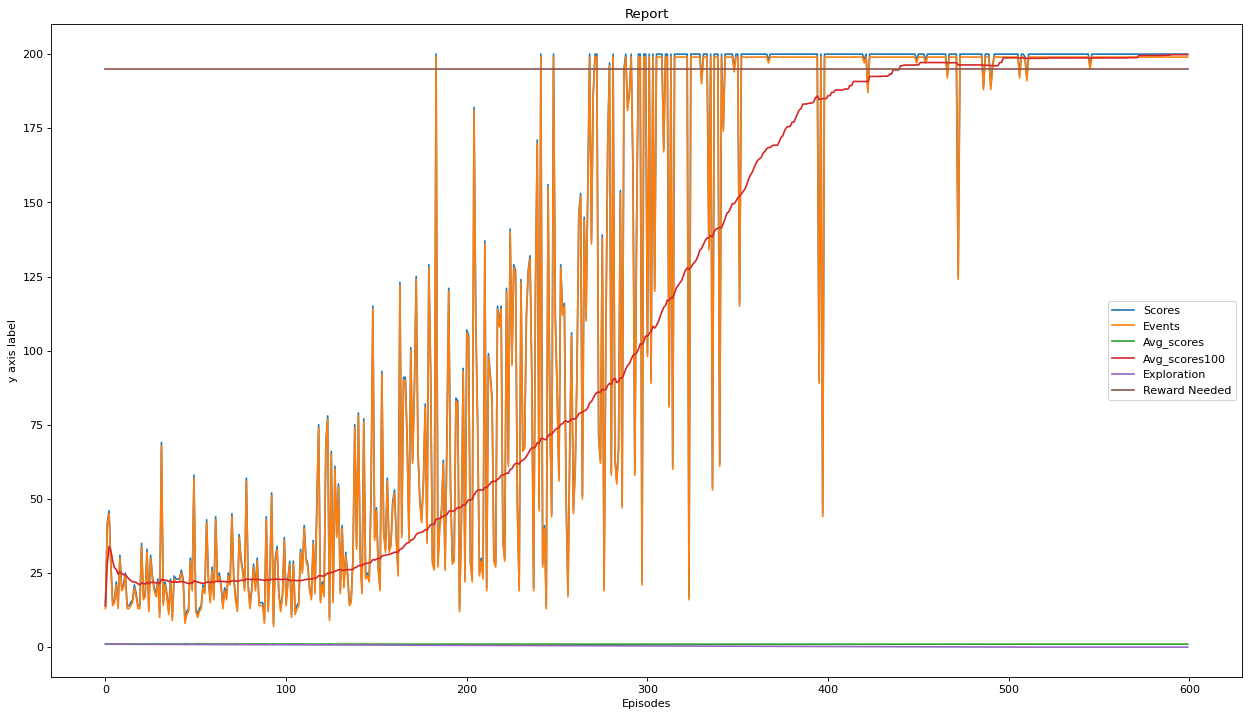

In [295]:
figure(figsize=(19.2, 10.8), dpi=80)
plt.plot(episodes, scores)
plt.plot(episodes, events)
plt.plot(episodes, avg_scores)
plt.plot(episodes, avg_scores100)
plt.plot(episodes, exploration)
a = []
a=[195 for i in range (TotalEpisodes)]
plt.plot(episodes,a)
plt.xlabel('Episodes')
plt.ylabel('y axis label')
plt.title('Report')
plt.legend(['Scores',  'Events', 'Avg_scores', 'Avg_scores100','Exploration','Reward Needed'])
plt.show()

In [296]:
#print(scores)
b=0
for i in  range (TotalEpisodes):
  b=b+scores[i]

print("Average score/epoch:",b/1000)

Average score/epoch: 75.932


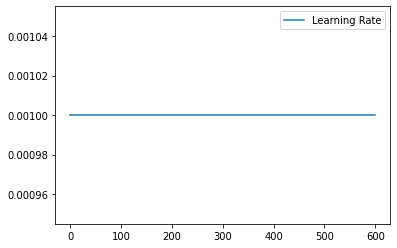

In [297]:
#plot da learning Rate
plt.plot(learning_rate)
plt.legend(["Learning Rate"])
plt.show()

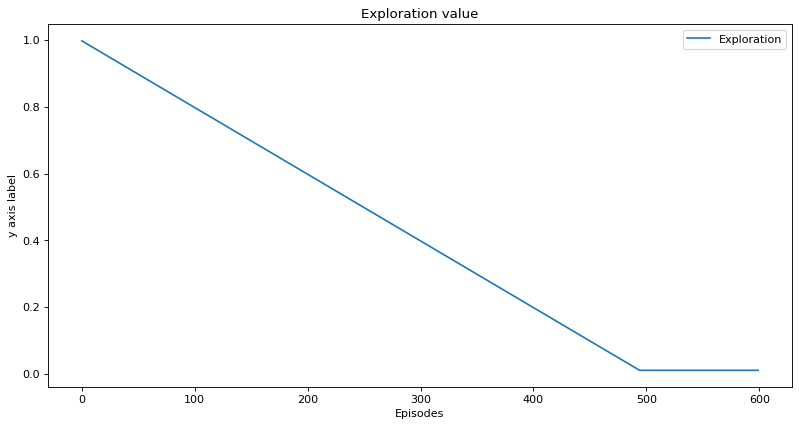

In [298]:
figure(figsize=(12, 6), dpi=80)
plt.plot(episodes, exploration)
plt.xlabel('Episodes')
plt.ylabel('y axis label')
plt.title('Exploration value')
plt.legend(['Exploration'])
plt.show()

In [299]:
#print(avg_scores100)
counter=0
episodio=0
index=[]
for i in range (TotalEpisodes):
  if(avg_scores100[i]>=195):
    counter+=1
    index.append(i)
#print(counter)
#percentagem
numeps=counter
counter = (counter/TotalEpisodes) *100
print("First Episode to get reward needed:",index[0])
print("Number of episodes with a reward higher than 195:",numeps)
print("Percentage of Episodes with 195 or higher reward: %.2f" %counter,"%",numeps)



First Episode to get reward needed: 440
Number of episodes with a reward higher than 195: 160
Percentage of Episodes with 195 or higher reward: 26.67 % 160


View Best Results

In [300]:
createMovie(bestNet,'bestNet')